# **Identifying Blood Cells - Aryan Khimanni** 
---
For thousands of years our eyes were the best at identifying objects from seeing dangerous animals to bacteria under a microscope, but with the advancements in object detection techniques the machine is far better at it than any human. 

To prove this I got data of 4 types of blood cells in the training and test data:
Neutrophil

1.  Neutrophil
2.  Eosinophil 
3.  Monocyte
4.  Lymphocyte

These can further be classified into Mononuclear (Lymphocyte + Monocyte) vs Polynuclear (Neutrophil + Eosinophil).

# **Loading the Data** 

First thing the machine needs to successfully learn to detect if what type of blood cell it found it must need data. 

In [1]:
# Imports used for loading the data
import os 
from tqdm import tqdm
import cv2
import numpy as np
np.set_printoptions(suppress=True)
from skimage import transform

# Unpacks the dataset 
def load_data(data):
    X = []
    y = []
    # To access all the folders easily
    for bloodcell_type in os.listdir(data):
        # Grouping the cells togther 
        if not bloodcell_type.startswith('.'):
            if bloodcell_type in ['NEUTROPHIL']:
                label = 1
            elif bloodcell_type in ['EOSINOPHIL']:
                label = 1
            elif bloodcell_type in ['MONOCYTE']:  
                label = 0
            elif bloodcell_type in ['LYMPHOCYTE']:
                label = 0
    
            # This loop is to access the training data 
            for filename in tqdm(os.listdir(data + '/' + bloodcell_type)):
                # To read every image in every folder
                image = cv2.imread(data +'/'+ bloodcell_type + '/' + filename)
                
            
                if image is not None:
                    # To resize the random sized images 
                    image = transform.resize(image, (80, 80, 3))
                    # Changing the datatype into array to process through the cnn algorithm
                    image_data_as_arr = np.asarray(image)
                    X.append(image_data_as_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y


# Loading the train and test data
X_train, y_train = load_data(r'../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/')
X_test, y_test = load_data(r'../input/blood-cells/dataset2-master/dataset2-master/images/TEST/')


100%|██████████| 623/623 [00:14<00:00, 42.45it/s]


# **Let's look at the four cells**

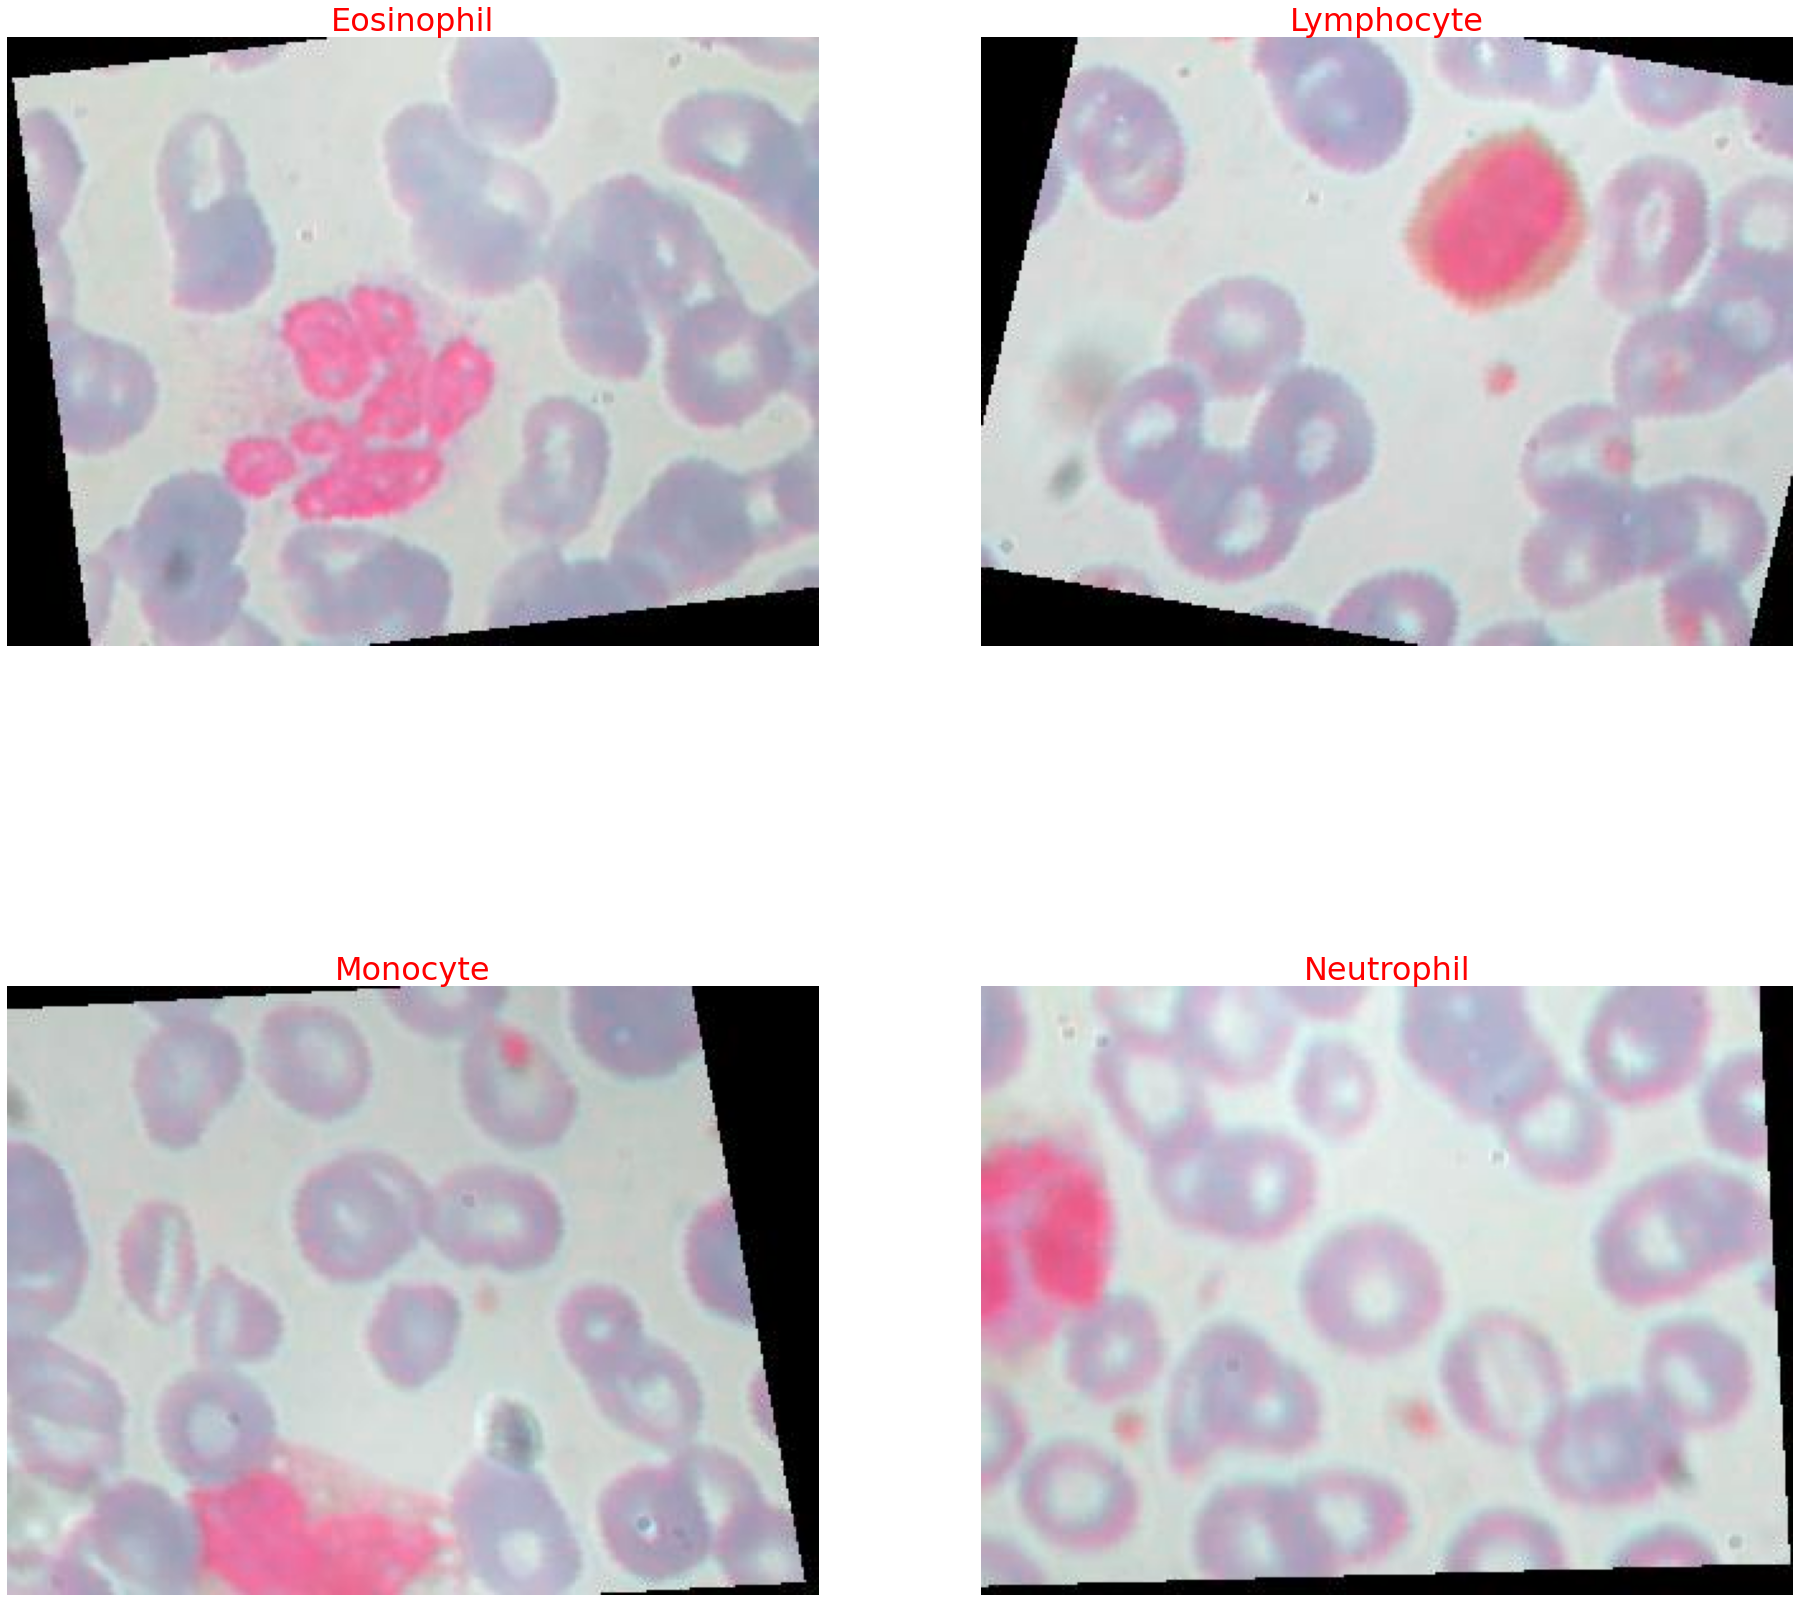

In [2]:
# Plot Image
 
import pandas as pd
import matplotlib.pyplot as plt

def plotImage(image_location):
    image = cv2.imread(image_name)
    plt.imshow(image)
    plt.axis('off') 

    #Plotting an EOSINOPHIL blood cell image
image_name = r'../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.figure(figsize=(32,32))
plt.subplot(221)
plt.title('Eosinophil',
          fontsize = 32,
          color = 'red')

plotImage(image_name)

    #Plotting an LYMPHOCYTE blood cell image
image_name = r'../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte',
          fontsize = 32,
          color = 'red')
plotImage(image_name)

    #Plotting an MONOCYTE blood cell image
image_name = r'../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte',
          fontsize = 32,
          color = 'red')
plotImage(image_name)
    
    #Plotting an NEUTROPHIL blood cell image
plt.subplot(224)
image_name = r'../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.title('Neutrophil',
          fontsize = 32,
          color = 'red') 
plotImage(image_name)

Now To look at the data in a more visual way, as since we have two classes, we will have two bar values. Mononuclear data consists of 5000 images and Polynuclear data also consists of 5000 images.

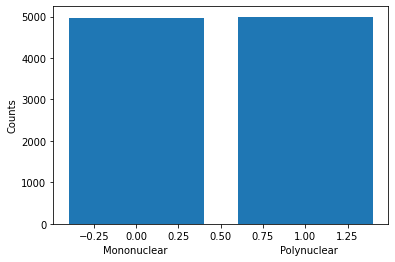

In [3]:
#To show the count of training data in each label
df = pd.DataFrame()
df["labels"] = y_train
counts = df['labels'].value_counts()
fig, ax = plt.subplots()
plt.bar(counts.index, counts.values)
ax.set_xlabel('Mononuclear                                    Polynuclear')
ax.set_ylabel('Counts')
plt.show()

Now we need to do a *one hot encoding* to be able to calculate loss during the back propogation. 

**One hot encoding**: This is basically taking words/letters into somthing the computer can understand like [0,1]

In [4]:
#One hot encoding 

from keras.utils.np_utils import to_categorical

#For training data
y_trainHot = np.uint8(to_categorical(y_train, num_classes = 2))

#For test data
y_testHot = np.uint8(to_categorical(y_test, num_classes = 2))


# **Let's take a look at the intensity of each pixel of the image**

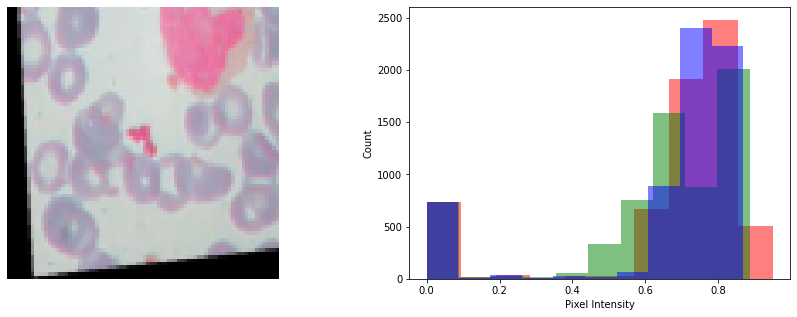

In [5]:
#To plot the intensity of each pixel of the image in the 3 different channels for red(r),green(g) and blue(b)
def plotHistogram(imag):
    
    #Figure size
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.imshow(imag)
    
    #Disable axis
    plt.axis('off')
    histog = plt.subplot(1,2,2)
    histog.set_ylabel('Count')
    histog.set_xlabel('Pixel Intensity')
    
    plt.hist(imag[:,:,0].flatten(), lw = 0, color='r', alpha=0.5);
    plt.hist(imag[:,:,1].flatten(), lw = 0, color='g', alpha=0.5);
    plt.hist(imag[:,:,2].flatten(), lw = 0, color='b', alpha=0.5);
    
plotHistogram(X_train[1])

# Createing a CNN model and use that model to train using the dataset.

A CNN model or also know as a Convolutional Neural Network is a Deep Learning algorithm that uses filters as a way to differentiate one image from the other.

Now to start we are going to make the main CNN architecture.


In [6]:
#The main CNN architecture
import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from sklearn.metrics import classification_report, confusion_matrix

#The binary labels for our CNN model in the form of a dictionary
bin_labels = {0:'Mononuclear',1:'Polynuclear'}

def CNN(imgs,img_labels,test_imgs,test_labels,stride):
    
    #Number of classes (2)
    num_classes = len(img_labels[0])
    
    epochs = 36
    
    #Size of image
    img_rows,img_cols=imgs.shape[1],imgs.shape[2]
    input_shape = (img_rows, img_cols, 3)
    
    #Creating the model
    model = Sequential()
    
    #First convolution layer
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     strides=stride))
    
    #First maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Second convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    #Second maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Third convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    
    #Third maxpooling layer
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #Convert the matrix to a fully connected layer
    model.add(Flatten())
    
    #Dense function to convert FCL to 128 values
    model.add(Dense(128, activation='relu'))
    
    #Final dense layer on which softmax function is performed
    model.add(Dense(num_classes, activation='softmax'))
    
    #Model parameters
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['binary_accuracy'])
    
    #Evaluate the model on the test data before training your model
    score = model.evaluate(test_imgs,test_labels, verbose=1)
    
    print('\nKeras CNN binary accuracy:', score[1],'\n')
    
    #The model details
    history = model.fit(imgs,img_labels,
                        shuffle = True, 
                        epochs=epochs, 
                        validation_data = (test_imgs, test_labels))
    
    #Evaluate the model on the test data after training your model
    score = model.evaluate(test_imgs,test_labels, verbose=1)
    print('\nKeras CNN binary accuracy:', score[1],'\n')
    
    #Predict the labels from test data
    y_pred = model.predict(test_imgs)
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(test_labels,axis=1)
    
    #Correct labels
    for i in range(len(Y_true)):
        if(Y_pred_classes[i] == Y_true[i]):
            print("The predicted class is : " , Y_pred_classes[i])
            print("The real class is : " , Y_true[i])
            break
            
    #The confusion matrix made from the real Y values and the predicted Y values
    confusion_mtx = [Y_true, Y_pred_classes]
    
    #Summary of the model
    model.summary()
    
    return model,confusion_mtx
   
model,conf_mat = CNN(X_train,y_trainHot,X_test,y_testHot,1);

78/78 [==============================] - 4s 40ms/step - loss: 0.6718 - binary_accuracy: 0.7078

Keras CNN binary accuracy: 0.49859267473220825 

Epoch 1/36
312/312 [==============================] - 53s 168ms/step - loss: 0.6951 - binary_accuracy: 0.5066 - val_loss: 0.6930 - val_binary_accuracy: 0.5014
Epoch 2/36
312/312 [==============================] - 52s 167ms/step - loss: 0.6914 - binary_accuracy: 0.5266 - val_loss: 0.6622 - val_binary_accuracy: 0.6610
Epoch 3/36
312/312 [==============================] - 52s 167ms/step - loss: 0.5577 - binary_accuracy: 0.7175 - val_loss: 0.5010 - val_binary_accuracy: 0.8010
Epoch 4/36
312/312 [==============================] - 51s 164ms/step - loss: 0.3800 - binary_accuracy: 0.8406 - val_loss: 0.2723 - val_binary_accuracy: 0.8918
Epoch 5/36
312/312 [==============================] - 52s 167ms/step - loss: 0.2104 - binary_accuracy: 0.9192 - val_loss: 0.2069 - val_binary_accuracy: 0.9131
Epoch 6/36
312/312 [==============================] - 51s 16